In [1]:
from dotenv import load_dotenv 
load_dotenv()

True

In [2]:
from langchain_openai import ChatOpenAI  

llm = ChatOpenAI(model='gpt-4o')
small_llm = ChatOpenAI(model='gpt-4o-mini') 

In [3]:
from langchain_core.tools import tool  

@tool 
def add(a: int, b: int) -> int:
    """Add two numbers together"""
    return a + b 

@tool 
def multiply(a: int, b: int) -> int:
    """Multiply two numbers together"""
    return a * b 

@tool
def translate_to_korean(query: str) -> str:
    """translate the query to korean"""
    return small_llm.invoke(query)



In [4]:
from langchain_community.tools import DuckDuckGoSearchRun

search_tool = DuckDuckGoSearchRun()


In [5]:
from langchain_google_community import GmailToolkit

from langchain_google_community.gmail.utils import (
    build_resource_service,
    get_gmail_credentials,
)

credentials = get_gmail_credentials(
    token_file="./google/gmail_token.json",
    scopes=["https://mail.google.com/"],
    client_secrets_file="./google/gmail_credentials.json",
)

api_resource = build_resource_service(credentials=credentials) 
gmail_toolkit = GmailToolkit(api_resource=api_resource) 
gmail_tool_list= gmail_toolkit.get_tools()  

In [6]:
gmail_tool_list

[GmailCreateDraft(api_resource=<googleapiclient.discovery.Resource object at 0x12ce8cd70>),
 GmailSendMessage(api_resource=<googleapiclient.discovery.Resource object at 0x12ce8cd70>),
 GmailSearch(api_resource=<googleapiclient.discovery.Resource object at 0x12ce8cd70>),
 GmailGetMessage(api_resource=<googleapiclient.discovery.Resource object at 0x12ce8cd70>),
 GmailGetThread(api_resource=<googleapiclient.discovery.Resource object at 0x12ce8cd70>)]

In [7]:
from langchain.agents import load_tools

loaded_tool_list = load_tools(
    ["arxiv"],
)

In [8]:
from langchain_chroma import Chroma 
from langchain_openai import OpenAIEmbeddings  
from langchain_core.tools.retriever import create_retriever_tool

embeddings = OpenAIEmbeddings(model='text-embedding-3-large')
vector_store = Chroma(
    embedding_function=embeddings,
    collection_name = 'real_estate_tax',
    persist_directory='./real_estate_tax_collection'
)

retriever = vector_store.as_retriever(search_kwargs={"k": 3})

retriever_tool = create_retriever_tool(
    retriever=retriever,
    name='real_estate_tax_retriever',
    description='Contains information about real estate tax up to December 2024',
)


In [9]:
from langgraph.prebuilt import ToolNode 

tool_list = [add, multiply, search_tool, translate_to_korean, retriever_tool] + gmail_tool_list + loaded_tool_list
llm_with_tools = llm.bind_tools(tool_list) 
tool_node = ToolNode(tool_list) 



In [10]:
from langgraph.graph import MessagesState, StateGraph  

graph_builder = StateGraph(MessagesState)

def agent(state: MessagesState) -> MessagesState:
    messages = state['messages']  

    response = llm_with_tools.invoke(messages)  
    # print(response)
    return {'messages': [response]}  

In [11]:
from typing import Literal
from langgraph.graph import END

def should_continue(state: MessagesState) -> Literal['tools', END]:
    """
    주어진 메시지 상태를 기반으로 에이전트가 계속 진행할지 여부를 결정합니다.

    Args:
        state (MessagesState): `state`를 포함하는 객체.

    Returns:
        Literal['tools', END]: 도구를 사용해야 하면 `tools`를 리턴하고, 
        답변할 준비가 되었다면 END를 반환해서 프로세스를 종료합니다.
    """
    # 상태에서 메시지를 추출합니다.
    messages = state['messages']
    
    # 마지막 AI 메시지를 가져옵니다.
    last_ai_message = messages[-1]
    
    # 마지막 AI 메시지가 도구 호출을 포함하고 있는지 확인합니다.
    if last_ai_message.tool_calls:
        # 도구 호출이 있으면 'tools'를 반환합니다.
        return 'tools'
    
    # 도구 호출이 없으면 END를 반환하여 프로세스를 종료합니다.
    return END

In [12]:
graph_builder.add_node('agent', agent)
graph_builder.add_node('tools', tool_node)

In [13]:
from langgraph.graph import START, END

graph_builder.add_edge(START, 'agent')
graph_builder.add_conditional_edges(
    'agent',
    should_continue,
    ['tools', END]
)
graph_builder.add_edge('tools', 'agent')

In [14]:
graph= graph_builder.compile()

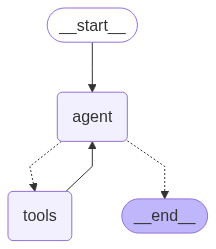

In [15]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

In [18]:
from langchain_core.messages import HumanMessage

query = '집이 15억 일 때 종합부동산세를 계산 과정을 정리해서 heather@hanpoom.com에게 메일을 바로 보내줘'

for chunk in graph.stream({'messages': [HumanMessage(query)]}, stream_mode='values'):
    chunk['messages'][-1].pretty_print()

================================ Human Message =================================

집이 15억 일 때 종합부동산세를 계산 과정을 정리해서 heather@hanpoom.com에게 메일을 바로 보내줘
================================== Ai Message ==================================
Tool Calls:
  real_estate_tax_retriever (call_9TjdES2jaO9MAxc6ZIEkbaqo)
 Call ID: call_9TjdES2jaO9MAxc6ZIEkbaqo
  Args:
    query: 15억 종합부동산세 계산
================================= Tool Message =================================
Name: real_estate_tax_retriever

| 45억원 초과 | 8천250만원+(45억원을 초과하는 금액의 1천분의 30) |
② 삭제<2008. 12. 26.>
③종합합산과세대상인 토지의 과세표준 금액에 대하여 해당 과세대상 토지의 토지분 재산세로 부과된 세액(「지방세법」 제111조제3항에 따라 가감조정된 세율이 적용된 경우에는 그 세율이 적용된 세액, 같은 법 제122조제1따라 세부담 상한률 적용받은 경우에는 그 상한률 적용받은 세액을 말한다)은 토지분 종합합산세액에서 이를 공제한다.
신설 2005. 12. 31, 2008. 12. 26, 2010. 3. 31.>
④별도합산과세대상인 토지에 대한 종합부동산세의 세액은 과세표준에 다음의 세율을 적용하여 계산한 금액(이하 “토지분 별도합산세액”이라 한다)으로 한다.<개정 2008. 12. 26.>
| 과세표준  | 세율  |
|---|---|
| 200억원 이하 | 1천분의 5 |
| 200억원 초과 400억원 이하 | 1억원+(200억원을 초과하는 금액의 1천분의 10) |
| 400억원 초과 | 